# Algorithmes de streaming : généralités

Les streams (flux) de données sont aujourd'hui présents dans de nombreux domaines (réseaux sociaux, e-commerce, logs de connexion Internet, etc.). L'analyse rapide et pertinente de ces flux est motivée par l'immensité des données qui ne peuvent souvent pas être stockés (du moins facilement) et dont le traitement serait trop lourd (penser au calcul de l'âge moyen des 1,86 milliards utilisateurs de Facebook pour s'en convaincre).

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Introduction

Plus formellement considérons un univers $U$ de taille $n$ (un nombre très grand) qui ne peut être stocké en mémoire et une séquence $S = (s_1, s_2, \ldots, s_m, \ldots)$ d'éléments de $U$. Un algorithme de streaming $\mathcal{A}$ prend le stream $S$ en entrée et renvoie une fonction $f(S)$ (souvent à valeurs réelles).

Notons que l'algorithme $\mathcal{A}$ est souvent contraint d'accéder séquentiellement aux éléments de $S$ et / ou ne peut les parcourir qu'un nombre fini de fois.

Un bon algorithme de streaming doit satisfaire plusieurs contraintes:

- Il doit être un bon estimateur de la vraie valeur que prendrait $f^*(U)$ sur l'univers (plus de détails dans un instant)
- Il doit pouvoir s'actualiser rapidement (en temps linéaire ou moins) à mesure que le flux $S$ évolue
- Il doit être peu gourmand en mémoire

Etant donné une précision $\epsilon > 0$ et une tolérance $\delta > 0$, l'algorithme $\mathcal{A}$ doît satisfaire:

$\mathbb{P}(\lvert \frac{f^*(U) - f(S)}{f(S)} \rvert \leq \epsilon) \geq 1 - \delta.$

Quelques exemples fréquents d'algorithmes de streaming:

- Estimation de la valeur moyenne, de la médiane
- Estimation du nombre d'éléments distincts
- Estimation de la fréquences des élements
- Estimation de la densité de probabilité

## Estimer le nombre d'éléments distincts: l'algorithme BJKST

L'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts) permet d'estimer le nombre d'éléments distincts d'un stream $S$. Son fonctionnement est assez simple et repose sur la notion d'universal hashing que nous présentons ci-bas.

### Universal hashing

L'idée derrière les fonctions de hachage est de faire correspondre des élements d'un ensemble dont la taille est variable (ou bien n'est pas connue) vers un ensemble de taille fixe. Le principe de l'universal hashing est de sélectionner aléatoirement une fonction $h$ dans une famille de fonctions de hachage $\mathcal{H}$ et de garantir un faible probabilité du nombre de collisions de hachage. 

Formellement si l'on note $[n]$ l'ensemble $\{1, \ldots, n\}$, une famille de fonctions $\mathcal{H}$ est dite <i>universelle</i> si toute fonction $h: U \mapsto [n]$ choisie uniformément dans la famille $\mathcal{H}$ vérifie $\mathbb{P}(h(x) = h(y)) \leq \frac{1}{n}$ pour tout couple $x,y \in U$ distincts.

Nous considérons ici la famille $\mathcal{H} = \{h_{a,b}\}$ où $h_{a,b}(x) = ((ax + b) \space{} \mathrm{mod} \space{} p) \space{} \mathrm{mod} \space{} n$, $x$ est un entier, $a \in \{1, \ldots, p - 1\}$, $b \in \{0, \ldots, p - 1 \}$ et $p$ un nombre premier $\geq n$. On peut sans trop de difficulté se convaincre que $h_{a,b}(x)$ est uniformément distribué sur $[n]$ et que cette famille est universelle (voir [ici](https://en.wikipedia.org/wiki/Universal_hashing) pour plus de détails).

### Algorithme BJKST

Nous considérons le stream $S = [n]$ et allons essayer d'estimer $n$ à l'aide de l'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts).

In [ ]:
n = 10000
stream = range(n)

L'idée derrière l'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts) est de parcourir les élements du stream et de remplir un ensemble $B$ par échantillonage. La probabilité d'échantillonage initiale est $1$ et lorsque $B$ devient trop grand (au delà d'un certain seuil $B_{max}$) on enlève des élements et on diminue la probabilité d'échantillonage. A la fin le nombre d'éléments dans $B$ et la probabilité d'échantillonage finale permettent d'estimer le nombre d'éléments distincts dans $U$.

Pour $\epsilon >0$ nous prenons $B_{max} = 1/ \epsilon^2$ :

In [ ]:
# definissons un ensemble B
B = set()
epsilon = 0.025
B_max = 1 / epsilon**2

Choisissons $p$ un nombre premier arbitrairement grand:

In [ ]:
p = 4294967291

et tirons aléatoirement deux fonctions $h_{a_1, b_1}$ et $h_{a_2, b_2}$ distinctes:

In [ ]:
import random
# deux couples (a_1, b_1) (a_1, b_2) distincts
a1, a2 = random.sample(range(1, p), 2)
b1, b2 = random.sample(range(0, p), 2)

def h1(x):
    return ((a1*x + b1) % p) % n

def h2(x):
    return ((a2*x + b2) % p) % n

Initialisons un entier $c$ à zero. Pour chaque $x$ dans le stream nous calculons d'abord sa valeur de hachage $y = h_{a_1, b_1}(x)$ :

In [ ]:
c = 0
# Prenons le premier élément du stream (à titre d'exemple)
x = stream[0]
y = h1(x)
print('x = {}, y = {}'.format(x, y))

x = 0, y = 3340


La probabilité d'échantillonage est basée sur le nombre de zéros à droite dans la décomposition binaire de $y$. Pour calculer ce nombre diverses méthodes existent (voir [ici](http://graphics.stanford.edu/~seander/bithacks.html#ZerosOnRightModLookup) pour plus de détails). Pour $s= 2^1$ et $s = 2^{10}$ la décomposition binaire comporte $1$ et $10$ zéros à droite respectivement:

In [ ]:
mod_37bit_position = (32, 0, 1, 26, 2, 23, 27, 0, 3, 16, 24, 30, 28, 11, 0, 13, 4,
  7, 17, 0, 25, 22, 31, 15, 29, 10, 12, 6, 0, 21, 14, 9, 5,
  20, 8, 19, 18)

# Un seul zéro à droite
s = 2**1
zeros = mod_37bit_position[(-s & s) % 37]
print('Decomposition binaire de 2**1 = {}, nombre de zeros a droite = {}'.format(bin(s), zeros))

# Dix zéros à droite
s = 2**10
zeros = mod_37bit_position[(-s & s) % 37]
print('Decomposition binaire de 2**10 = {}, nombre de zeros a droite = {}'.format(bin(s), zeros))

Decomposition binaire de 2**1 = 0b10, nombre de zeros a droite = 1
Decomposition binaire de 2**10 = 0b10000000000, nombre de zeros a droite = 10


Notons $k$ le nombre de zéros à droite dans la décomposition binaire de $y$.

In [ ]:
k = mod_37bit_position[(-y & y) % 37]
print('Decomposition binaire de y = {}, nombre de zeros a droite = {}'.format(bin(y), k))

Decomposition binaire de y = 0b110100001100, nombre de zeros a droite = 2


Puis nous comparons $k \geq c$. Si c'est le cas nous calculons une nouvelle valeur de hashage de $x$, $z = h_{a_2, b_2}(x)$ et rajoutons le couple $(z, k)$ à l'ensemble $B$.

In [ ]:
if (k >= c):
    z = h2(x)
    B.add((z, k))

A l'initialisation la condition $k \geq c$ est toujours vérifiée (ce qui correspond à une probabilité d'échantillonage égale à $1$) :

In [ ]:
B

{(3753, 2)}

L'ensemble $B$ se remplit jusqu'à atteindre la taille $B_{max}$. Lorsque cette taille est atteinte on incrémente $c$ et on enlève à $B$ tous les couples $(z, k)$ où $k < c$.

In [ ]:
while (len(B) >= B_max):
    c += 1
    # on prend ici une copie de B
    for z, k in B.copy():
        if (k < c):
            B.remove((z, k))   

Parcourons le stream et regardons à quoi ressemble l'ensemble $B$:

In [ ]:
for x in stream:
    y = h1(x)
    k = mod_37bit_position[(-y & y) % 37]
    if (k >= c):
        z = h2(x)
        B.add((z, k))
        while (len(B) >= B_max):
            c += 1
            for z, k in B.copy():
                if (k < c):
                    B.remove((z, k)) 

In [ ]:
print('Taille de B = {}, c = {}'.format(len(B), c))

Taille de B = 976, c = 3


Une estimateur de la taille de l'univers est alors $2^c \mathrm{card}(B)$ :

In [ ]:
print('Estimation de la taille de U = {}'.format(2**c * len(B)))

Estimation de la taille de U = 7808


Pour s'en convaincre, remarquons qu'en moyenne le cardinal de $B$ est égal au nombre de $y_i$ pour lequel le nombre de zéros à droite dans la décomposition binaire est plus grand que $c$. Ceci correspond au nombre de $y_i$ qui sont divisibles par $2^c$ :

$$\mathbb{E}[\mathrm{card}(B)] = \mathbb{E}\big[\sum_{x_i} I(y_i = 0 \space{} \mathrm{mod} \space{} 2^c)\big] = \sum_{x_i} \mathbb{P}\big( y_i = 0 \space{} \mathrm{mod} \space{} 2^c\big)$$

C'est ici qu'intervient la notion de famille universelle car cette derniere égalité n'est valide que si le nombre de collision entre $y$ et $z$ est faible lors du hachage de $x$ par $h_{a_1, b_1}$ et $h_{a_2, b_2}$. En effet, si le nombre de collisions était trop grand la taille de $B$ sous-estimerait le nombre d'éléments distincts.

La probabilité $\mathbb{P}\big( y_i = 0 \space{} \mathrm{mod} \space{} 2^c\big)$ étant égale à $1 / 2^c$ si $y_i$ est distribué uniformément (l'écrire pour s'en convaincre) nous obtenons :

$$ \mathbb{E}[\mathrm{card}(B)] = \frac{n}{2^c}.$$

### Résultats numériques

Regroupons le code dans une fonction

In [ ]:
def BJKST(stream, epsilon):
    a1, a2 = random.sample(range(1, p), 2)
    b1, b2 = random.sample(range(0, p), 2)
    def h1(x):
        return ((a1*x + b1) % p) % n
    def h2(x):
        return ((a2*x + b2) % p) % n
    c = 0
    B = set()
    B_max = 1.0 / epsilon**2
    for x in stream:
        y = h1(x)
        k = mod_37bit_position[(-y & y) % 37]
        if (k >= c):
            z = h2(x)
            B.add((z, k))
            while (len(B) >= B_max):
                c += 1
                for z, k in B.copy():
                    if (k < c):
                        B.remove((z, k))             
    return 2**c*len(B)

En pratique une estimation fiable du nombre d'éléments distincts requiert de générer $m$ calculs indépendants de l'algorithme et de prendre la médiane. Regardons comment la qualité de l'estimation évolue en fonction de la précision $\epsilon$ exigée :

In [ ]:
import numpy as np
m = 100
epsilons = np.array([0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])
medians = np.array([np.median([BJKST(stream, eps) for _ in range(m)]) for eps in epsilons])

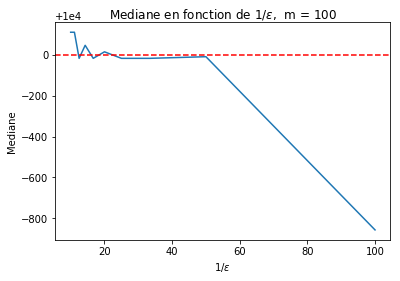

In [ ]:
import matplotlib.pyplot as plt

plt.plot(1.0 / epsilons, medians)
plt.axhline(y=n, color='r', linestyle='--')
plt.title(r'Mediane en fonction de $1 / \epsilon$,  m = {}'.format(m))
plt.xlabel(r'$1 / \epsilon$')
plt.ylabel('Mediane')

La fiabilité de l'estimation est décroissante avec le niveau de précision exigé, l'algorithme donne une bonne estimation de la vraie valeur (ligne horizontale rouge) pour $\epsilon \approx 0.3$.

### Temps de calcul en fonction de la taille du stream

Regardons à présent comment le temps de calcul évolue en fonction de la taille du stream. Rappelons qu'un bon algorithme de streaming doit évoluer de manière au pire linéaire en fonction de la taille d'espace $n$.

In [ ]:
import math
import time 
epsilon = 0.03
size_bound = 15
stream_sizes = [2**s for s in range(1, size_bound)]
m = 100
times = []
for s in stream_sizes:
    start = time.time()
    BJKST(range(s), epsilon)
    times.append(time.time() - start)

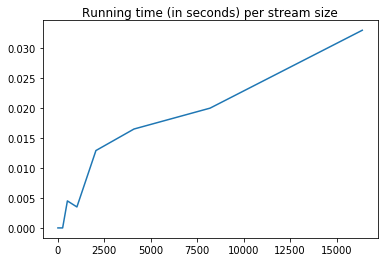

In [ ]:
fix, ax = plt.subplots()
plt.plot(stream_sizes, times)
ax.set_title('Running time (in seconds) per stream size')

La complexité semble être linéaire ce qui est satisfaisant. Notons qu'aucun effort d'optimisation de performance (à part l'usage d'un <b>set</b>) n'a été fait à ce stade.